# Решение задачи классификации с помощью ансамблевых методов

## Собственная реализация Bagging и AdaBoost

In [1]:
!pip install pandas==1.5.3
!pip install matplotlib==3.7.1
!pip install seaborn==0.12.2
!pip install scikeras==0.10.0
!pip install xgboost==1.7.4
!pip install lightgbm==3.3.5
!pip install catboost==1.1.1
!pip install optuna==3.1.0
!pip install botorch==0.7.3

In [2]:
import time
import signal

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from contextlib import contextmanager
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from optuna.integration import BoTorchSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaseEnsemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier

In [3]:
MAX_SEED = 2 ** 32 - 1

class MyBaggingClassifier(BaseEnsemble):
    def __init__(self, estimator=None, n_estimators=10, *, random_state=None):
        super().__init__(
            estimator=estimator,
            n_estimators=n_estimators
        )
        self.random_state = random_state
        self.estimators_ = None

    def fit(self, X, y):
        self._validate_estimator()
        self.estimators_ = []
        for _ in range(self.n_estimators):
            self._make_estimator(append=True)
        rng = np.random.default_rng(self.random_state)
        for estimator in self.estimators_:
            X_resampled, y_resampled = resample(X, y, random_state=rng.integers(MAX_SEED))
            estimator.fit(X_resampled, y_resampled)

    def predict(self, X):
        return np.around(sum((estimator.predict(X) for estimator in self.estimators_)) / self.n_estimators)

    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)


class MyAdaBoostClassifier(BaseEnsemble):
    def __init__(self, estimator=None, n_estimators=50, *, random_state=None):
        super().__init__(
            estimator=estimator,
            n_estimators=n_estimators
        )
        self.random_state = random_state
        self.estimators_ = None
        self.alphas = None

    def fit(self, X, y):
        self._validate_estimator()
        self.estimators_ = []
        for _ in range(self.n_estimators):
            self._make_estimator(append=True)
        self.alphas = [0 for _ in range(self.n_estimators)]
        weight = [1.0 for _ in y]
        for i in range(self.n_estimators):
            self.estimators_[i].fit(X, y, weight)
            err = 1 - self.estimators_[i].score(X, y, weight)
            self.alphas[i] = np.log((1 - err) / err)
            weight = weight * np.exp(self.alphas[i] * (y != self.estimators_[i].predict(X)))
            weight = weight / sum(weight) * len(y)
        self.alphas /= sum(self.alphas)

    def predict(self, X):
        return np.around(
            sum((self.alphas[i] * self.estimators_[i].predict(X) for i in range(self.n_estimators)))
        )

    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)

## Обёртка для использования Optuna

In [4]:
class TimeoutException(Exception):
    pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")

    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

class OptunaSearchCV:
    def __init__(
            self,
            cv,
            model_factory,
            timeout=2*60*60,
            n_trials = None,
            trial_timeout=None,
            seed=15,
            default_params=None
    ):
        self.cv = cv
        self.model_factory = model_factory
        self.timeout = timeout
        self.n_trials = n_trials
        self.trial_timeout = trial_timeout
        self.seed = seed
        self.default_params = default_params
        self.best_model = None
        self.best_trial = None

    def fit(self, X, y):
        def objective(trial):
            model = self.model_factory(trial)
            try:
                if self.trial_timeout is None:
                    score = cross_val_score(model, X, y, cv=self.cv)
                else:
                    with time_limit(self.trial_timeout):
                        score = cross_val_score(model, X, y, cv=self.cv)
            except TimeoutException as e:
                print("Timeout")
                return 0.5
            print("Score:", score.mean(), score)
            return score.mean()

        study = optuna.create_study(sampler=BoTorchSampler(seed=self.seed), direction='maximize')
        if self.default_params is not None:
            study.enqueue_trial(self.default_params)
        study.optimize(objective, timeout=self.timeout, n_trials=self.n_trials)
        print("Best trial:", study.best_trial)
        self.best_trial = study.best_trial
        self.best_model = self.model_factory(self.best_trial)
        self.n_trials = len(study.trials)
        self.best_model.fit(X, y)

    def predict(self, X):
        return self.best_model.predict(X)

## Оборудование (для воспроизведения замеров по времени)

In [5]:
!printf '========== OS  ==========\n'
!grep '^NAME=' /etc/os-release
!grep '^VERSION=' /etc/os-release

!printf '\n========== CPU ==========\n'
!lscpu | grep -E 'Architecture|Model name|Threads|Cores|MHz'

!printf '\n========== GPU ==========\n'
!nvidia-smi -L | grep -o 'NVIDIA .* (' | sed 's/ (//'
!nvidia-smi | grep -o 'CUDA Version: [0-9.]*'
!nvidia-smi --query-gpu=memory.total --format=csv | grep '[0-9]* MiB'

!printf '\n========== RAM ==========\n'
!free -m

========== OS  ==========
NAME="Ubuntu"
VERSION="22.04.1 LTS (Jammy Jellyfish)"

========== CPU ==========
Architecture:                    x86_64
Model name:                      Intel(R) Core(TM) i3-8130U CPU @ 2.20GHz
CPU max MHz:                     3400.0000
CPU min MHz:                     400.0000

========== GPU ==========
NVIDIA GeForce MX130
CUDA Version: 12.0
2048 MiB

========== RAM ==========
               total        used        free      shared  buff/cache   available
Mem:           11846        4102        3073         368        4669        7062
Swap:          11718           0       11718


## Решение задачи классификации

Загрузим предобработанный в предыдущем Jupyter Notebook набор данных

In [6]:
df = pd.read_csv("prepared_place.csv")

In [7]:
print(df.shape)

(33599, 345)


In [8]:
df.iloc[500:600]

,y,z,yaw,pitch,key_forward,key_back,key_left,key_right,key_jump,key_sneak,...,vel_y,vel_z,rel_block_x,rel_block_y,rel_block_z,yaw_sin,yaw_cos,x_frac,y_frac,z_frac
500,102.000000,1992.653720,95.406750,45.863773,True,False,False,False,True,False,...,0.000000,-0.019441,-1.266389,-1.000000,-0.153720,0.995551,-0.094226,0.766389,0.000000,0.653720
501,102.420000,1992.612264,95.801500,45.626904,True,False,False,False,True,False,...,0.420000,-0.041456,-0.793736,-0.420000,-0.112264,0.994878,-0.101082,0.293736,0.420000,0.612264
502,102.753200,1992.587053,95.485700,45.547947,True,False,False,False,True,False,...,0.333200,-0.025210,-1.510318,0.246800,-0.087053,0.995420,-0.095597,0.010318,0.753200,0.587053
503,103.001336,1992.561678,94.104095,45.034730,True,False,False,False,True,False,...,0.248136,-0.025376,-1.227045,-0.001336,-0.061678,0.997436,-0.071569,0.727045,0.001336,0.561678
504,103.249187,1992.512723,90.827644,42.705510,True,False,False,False,False,False,...,0.083078,-0.024040,-2.660701,-2.249187,-0.012723,0.999896,-0.014445,0.160701,0.249187,0.512723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,106.176759,1994.800028,153.478960,69.549410,True,False,True,False,False,False,...,-0.075444,0.101076,-0.486620,-0.176759,-0.300028,0.446526,-0.894770,0.986620,0.176759,0.800028
596,106.024424,1994.883769,162.558760,70.062580,True,False,True,False,False,False,...,-0.152335,0.083741,-0.369329,-0.024424,-0.383769,0.299728,-0.954025,0.869329,0.024424,0.883769
597,106.000000,1994.889169,211.945280,74.246870,False,True,True,False,False,True,...,0.000000,0.011966,-0.305407,-1.000000,-0.389169,-0.529109,-0.848554,0.805407,0.000000,0.889169
598,106.000000,1994.905096,212.300550,74.286350,False,True,True,False,False,True,...,0.000000,0.015927,-0.246960,-1.000000,-0.405096,-0.534360,-0.845257,0.746960,0.000000,0.905096


Заменим `"["` и `"]"` в именах столбцов на `"_"`, так как некоторые библиотеки не разрешают использовать квадратные скобки в именах столбцов

In [9]:
df = df.rename(lambda name: name.replace("[", "_").replace("]", "_"), axis=1)

In [10]:
X = df.drop(["will_place"], axis=1)
y = df["will_place"].astype(int)

При разделении на тестовый и тренировочный набор не будем перемешивать данные, так как соседние элементы набора данных зачастую крайне похожи и желательно минимизировать попадание рядом стоящих элементов в тестовый и тренировочный наборы данных

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

По тем же причинам не будем перемешивать выборку при разделении на части для кросс-валидация и не будем использовать стратифицированную кросс-валидацию

In [12]:
cv = KFold(n_splits=5, shuffle=False)

Инициализируем массивы для заполнения результатами экспериментов

In [13]:
train_times = []
run_times = []
accuracy = []
recall = []
roc_auc = []
precision = []
estimator_names = []
confusion_matrices = []
trials = []

Вспомогательная функция для оценки модели и сохранения результатов

In [14]:
def eval_estimator(estimator_name, estimator):
    time_before = time.time()
    estimator.fit(X_train, y_train)
    train_times.append(time.time() - time_before)
    time_before = time.time()
    y_pred = estimator.predict(X_test)
    estimator_names.append(estimator_name)
    run_times.append(time.time() - time_before)
    accuracy.append(accuracy_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    trials.append(estimator.n_trials if hasattr(estimator, "n_trials") else 1)

Вспомогательная функция для построения графика, показывающего, как меняется точность модели при увеличении некоторого ресурса (например, числа деревьев или итераций)

In [15]:
def plot_accuracy_against_resource(estimator_name, resource_name: str, resource_points: list, create_estimator):
    train_score = []
    test_score = []
    for resource in resource_points:
        estimator = create_estimator(resource)
        estimator.fit(X_train, y_train)
        train_score.append(accuracy_score(y_train, estimator.predict(X_train)))
        test_score.append(accuracy_score(y_test, estimator.predict(X_test)))

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title(estimator_name)
    plt.plot(resource_points, train_score, "b-", label="Training Set")
    plt.plot(resource_points, test_score, "r-", label="Test Set")
    plt.legend(loc="lower right")
    plt.xlabel(resource_name)
    plt.ylabel("Accuracy")
    fig.tight_layout()
    plt.show()

Замеры для моделей со значениями гиперпараметров по умолчанию

In [16]:
eval_estimator("MyBagging_default", MyBaggingClassifier(DecisionTreeClassifier(), random_state=0))
eval_estimator("Bagging_default", BaggingClassifier(DecisionTreeClassifier(), random_state=0))
eval_estimator("MyAdaBoost_default", MyAdaBoostClassifier(DecisionTreeClassifier(max_depth=4), random_state=0))
eval_estimator("AdaBoost_default", AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), random_state=0))
eval_estimator("RandomForest_default", RandomForestClassifier(random_state=0))
eval_estimator("GradientBoosting_default", GradientBoostingClassifier(random_state=0))
eval_estimator("HistGradientBoosting_default", HistGradientBoostingClassifier(random_state=0))
eval_estimator("XGB_default", XGBClassifier(random_state=0))
eval_estimator("LGBM_default", LGBMClassifier(random_state=0))
eval_estimator("CatBoost_default", CatBoostClassifier(verbose=False, random_state=0))

Промежуточные результаты

In [17]:
pd.DataFrame({
    'Accuracy': [f'{x:.4f}' for x in accuracy],
    'Recall': [f'{x:.4f}' for x in recall],
    'Roc_Auc': [f'{x:.4f}' for x in roc_auc],
    'Precision': [f'{x:.4f}' for x in precision],
    'Trials': trials,
    'Time to train, sec': [f'{x:.0f}' for x in train_times],
    'Time to run (on test), sec': [f'{x:.2f}' for x in run_times],
}, index=estimator_names)

,Accuracy,Recall,Roc_Auc,Precision,Trials,"Time to train, sec","Time to run (on test), sec"
MyBagging_default,0.9432,0.9306,0.9416,0.9361,1,14,0.10
Bagging_default,0.9450,0.9311,0.9433,0.9398,1,8,0.11
MyAdaBoost_default,0.9246,0.9206,0.9241,0.9047,1,20,0.46
AdaBoost_default,0.9329,0.9239,0.9318,0.9196,1,16,0.24
RandomForest_default,0.9436,0.9306,0.9419,0.9369,1,5,0.17
GradientBoosting_default,0.9156,0.9276,0.9171,0.8812,1,22,0.05
HistGradientBoosting_default,0.9528,0.9552,0.9531,0.9357,1,9,0.05
XGB_default,0.9562,0.9582,0.9564,0.9403,1,27,0.21
LGBM_default,0.9508,0.9515,0.9509,0.9346,1,4,0.32
CatBoost_default,0.9597,0.9603,0.9598,0.9463,1,16,0.06


Замеры для моделей с подобранными гиперпараметрами, на подбор гиперпараметров для каждой модели отводилось по 2 часа.

Для моделей из библиотек xgboost, lightgbm и catboost при подборе учитываются хорошо показавшие себя значения гиперпараметров по умолчанию.

Также после подбора гиперпараметров исследуется, как изменяется точность модели с подобранными гиперпараметрами при изменении числа деревьев/итераций.

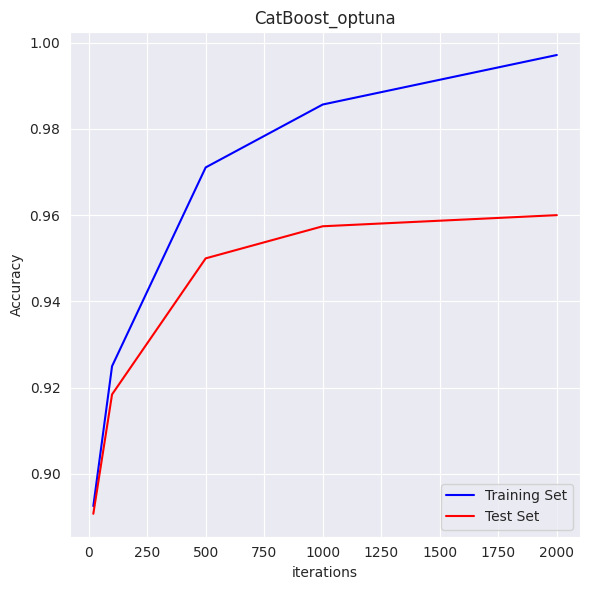

In [19]:
def create_cat_boost(trial: optuna.trial.Trial, iterations = None):
    params = {
        'iterations': trial.suggest_int("iterations", 100, 1000) if iterations is None else iterations,
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 2, 15),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-12, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-12, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 1e-12, 100.0, log=True),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50)
    }
    return CatBoostClassifier(verbose=False, random_state=0, **params)

estimator = OptunaSearchCV(cv, create_cat_boost, default_params={
   'iterations': 1000,
   'learning_rate': 0.03,
   'depth': 6,
   'l2_leaf_reg': 0.3,
   'random_strength': 1.0,
   'bagging_temperature': 1.0,
   'od_type': "IncToDec",
   'od_wait': 20
})
eval_estimator("CatBoost_optuna", estimator)
plot_accuracy_against_resource(
    "CatBoost_optuna",
    "iterations",
    [20, 100, 500, 1000, 2000],
    lambda n_estimators: create_cat_boost(estimator.best_trial, n_estimators)
)
eval_estimator("CatBoost_max_resource", create_cat_boost(estimator.best_trial, 2000))

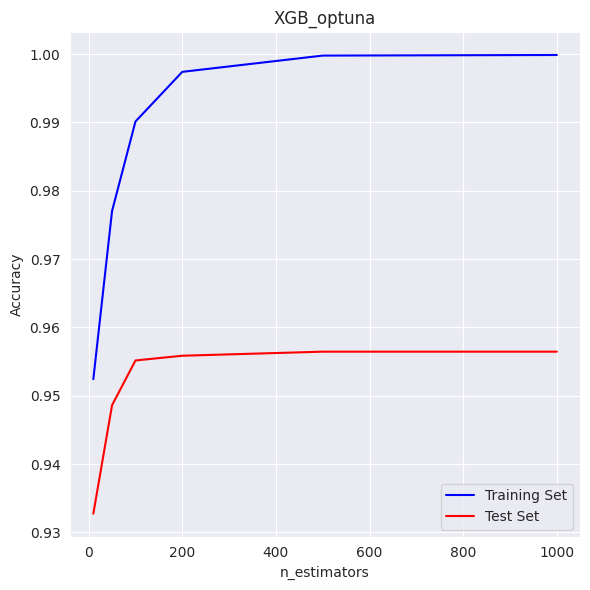

In [21]:
def create_xgboost(trial: optuna.trial.Trial, n_estimators = None):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500) if n_estimators is None else n_estimators,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-12, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-12, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-12, 1.0, log=True),
    }
    return XGBClassifier(random_state=0, **params)


estimator = OptunaSearchCV(cv, create_xgboost, default_params={
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'min_child_weight': 1,
    'gamma': 1e-12,
    'subsample': 1,
    'colsample_bytree': 1,
    'reg_alpha': 1e-12,
    'reg_lambda': 1,
})
eval_estimator("XGB_optuna", estimator)
plot_accuracy_against_resource(
    "XGB_optuna",
    "n_estimators",
    [10, 50, 100, 200, 500, 1000],
    lambda n_estimators: create_xgboost(estimator.best_trial, n_estimators)
)
eval_estimator("XGB_max_resource", create_xgboost(estimator.best_trial, 1000))

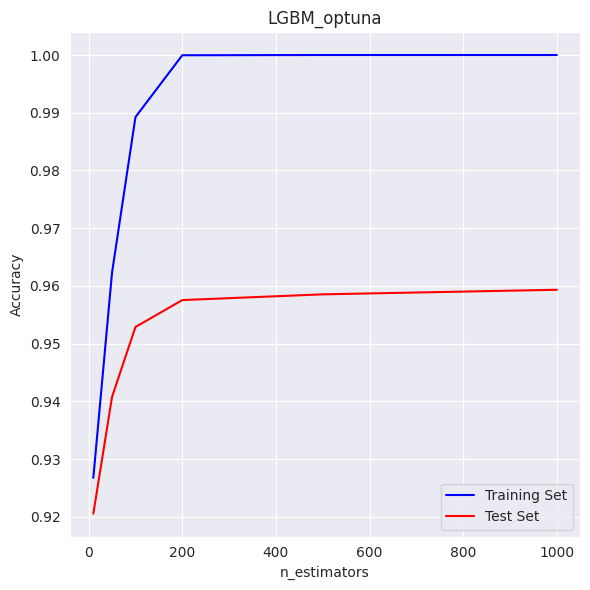

In [23]:
def create_lgbm(trial: optuna.trial.Trial, n_estimators = None):
    params = {
        'num_leaves': trial.suggest_int("num_leaves", 2, 512),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'min_child_samples': trial.suggest_int("min_child_samples", 5, 100),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500) if n_estimators is None else n_estimators,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-12, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-12, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
    }
    return LGBMClassifier(random_state=0, **params)

estimator = OptunaSearchCV(cv, create_lgbm, default_params={
    'num_leaves': 31,
    'learning_rate': 0.1,
    'min_child_samples': 20,
    'n_estimators': 100,
    'reg_alpha': 1e-12,
    'reg_lambda': 1e-12,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
})
eval_estimator("LGBM_optuna", estimator)
plot_accuracy_against_resource(
    "LGBM_optuna",
    "n_estimators",
    [10, 50, 100, 200, 500, 1000],
    lambda n_estimators: create_lgbm(estimator.best_trial, n_estimators)
)
eval_estimator("LGBM_max_resource", create_lgbm(estimator.best_trial, 1000))

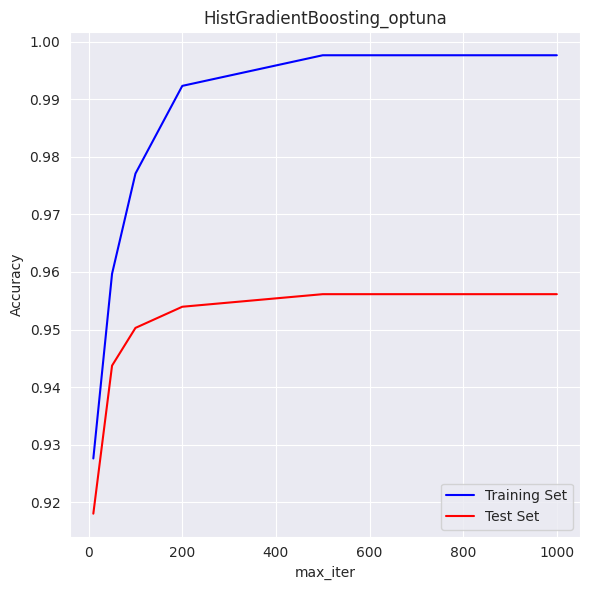

In [25]:
def create_hist_gradient_boosting(trial: optuna.trial.Trial, max_iter = None):
    return HistGradientBoostingClassifier(
        max_depth=trial.suggest_int("max_depth", 1, 50, log=True),
        min_samples_leaf=trial.suggest_int("min_samples_split", 1, 100, log=True),
        max_bins=trial.suggest_int("max_bins", 2, 255, log=True),
        max_iter=trial.suggest_int("max_iter", 5, 500, log=True) if max_iter is None else max_iter,
        random_state=0
    )

estimator = OptunaSearchCV(cv, create_hist_gradient_boosting)
eval_estimator("HistGradientBoosting_optuna", estimator)
plot_accuracy_against_resource(
    "HistGradientBoosting_optuna",
    "max_iter",
    [10, 50, 100, 200, 500, 1000],
    lambda max_iter: create_hist_gradient_boosting(estimator.best_trial, max_iter)
)
eval_estimator("HistGradientBoosting_max_resource", create_hist_gradient_boosting(estimator.best_trial, 1000))

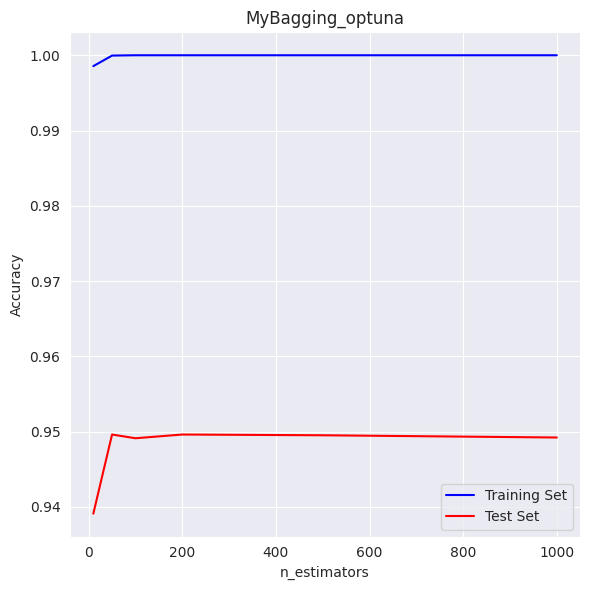

In [27]:
def create_my_bagging(trial: optuna.trial.Trial, n_estimators = None):
    return MyBaggingClassifier(
        estimator=DecisionTreeClassifier(
            criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
            splitter=trial.suggest_categorical("splitter", ["best", "random"]),
            max_depth=trial.suggest_int("max_depth", 1, 500, log=True),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 100, log=True),
            max_features=trial.suggest_int("max_features", 2, len(X_train.columns), log=True)
        ),
        n_estimators=trial.suggest_int("n_estimators", 5, 500, log=True) if n_estimators is None else n_estimators,
        random_state=0
    )

estimator = OptunaSearchCV(cv, create_my_bagging)
eval_estimator("MyBagging_optuna", estimator)
plot_accuracy_against_resource(
    "MyBagging_optuna",
    "n_estimators",
    [10, 50, 100, 200, 500, 1000],
    lambda n_estimators: create_my_bagging(estimator.best_trial, n_estimators)
)
eval_estimator("MyBagging_max_resource", create_my_bagging(estimator.best_trial, 1000))

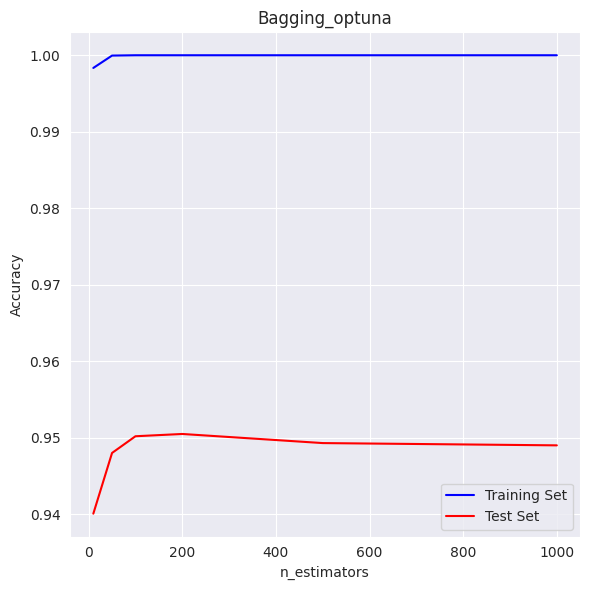

In [29]:
def create_bagging(trial: optuna.trial.Trial, n_estimators = None):
    return BaggingClassifier(
        estimator=DecisionTreeClassifier(
            criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
            splitter=trial.suggest_categorical("splitter", ["best", "random"]),
            max_depth=trial.suggest_int("max_depth", 1, 500, log=True),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 100, log=True),
            max_features=trial.suggest_int("max_features", 2, len(X_train.columns), log=True)
        ),
        n_estimators=trial.suggest_int("n_estimators", 5, 500, log=True) if n_estimators is None else n_estimators,
        random_state=0
    )

estimator = OptunaSearchCV(cv, create_bagging)
eval_estimator("Bagging_optuna", estimator)
plot_accuracy_against_resource(
    "Bagging_optuna",
    "n_estimators",
    [10, 50, 100, 200, 500, 1000],
    lambda n_estimators: create_bagging(estimator.best_trial, n_estimators)
)
eval_estimator("Bagging_max_resource", create_bagging(estimator.best_trial, 1000))

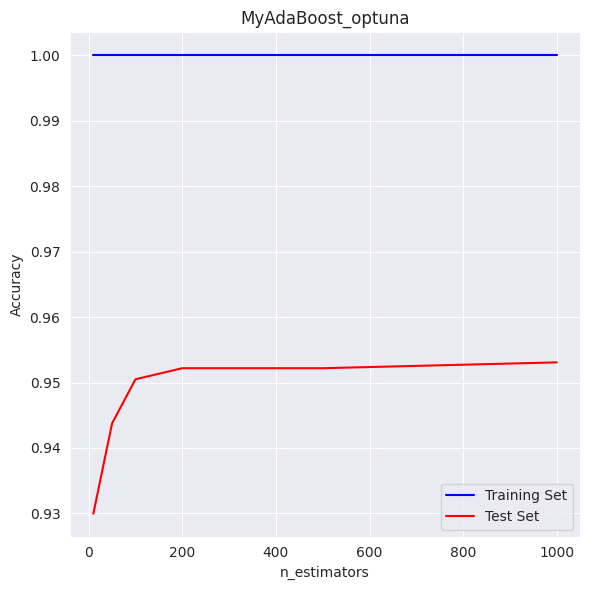

In [31]:
def create_my_ada_boost(trial: optuna.trial.Trial, n_estimators = None):
    return MyAdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
            max_depth=trial.suggest_int("max_depth", 1, 50, log=True),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 100, log=True),
            max_features=trial.suggest_int("max_features", 2, len(X_train.columns), log=True),
        ),
        n_estimators=trial.suggest_int("n_estimators", 5, 500, log=True) if n_estimators is None else n_estimators,
        random_state=0
    )

estimator = OptunaSearchCV(cv, create_my_ada_boost)
eval_estimator("MyAdaBoost_optuna", estimator)
plot_accuracy_against_resource(
    "MyAdaBoost_optuna",
    "n_estimators",
    [10, 50, 100, 200, 500, 1000],
    lambda n_estimators: create_my_ada_boost(estimator.best_trial, n_estimators)
)
eval_estimator("MyAdaBoost_max_resource", create_my_ada_boost(estimator.best_trial, 1000))

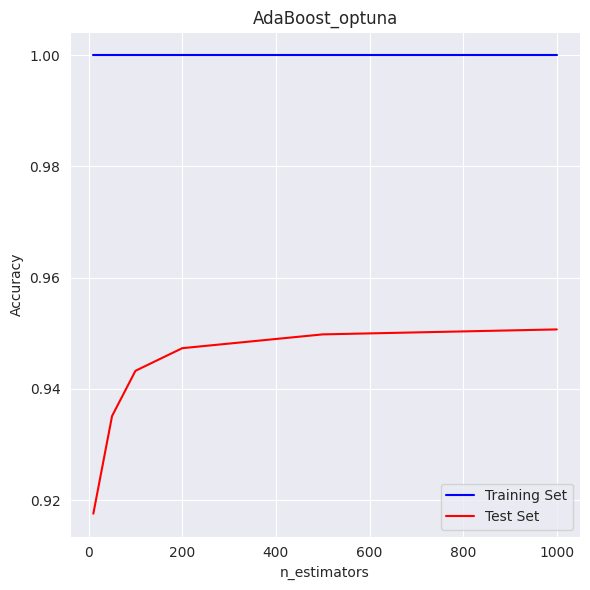

In [33]:
def create_ada_boost(trial: optuna.trial.Trial, n_estimators = None):
    return AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
            max_depth=trial.suggest_int("max_depth", 1, 50, log=True),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 100, log=True),
            max_features=trial.suggest_int("max_features", 2, len(X_train.columns), log=True),
        ),
        n_estimators=trial.suggest_int("n_estimators", 5, 500, log=True) if n_estimators is None else n_estimators,
        random_state=0
    )

estimator = OptunaSearchCV(cv, create_ada_boost)
eval_estimator("AdaBoost_optuna", estimator)
plot_accuracy_against_resource(
    "AdaBoost_optuna",
    "n_estimators",
    [10, 50, 100, 200, 500, 1000],
    lambda n_estimators: create_ada_boost(estimator.best_trial, n_estimators)
)
eval_estimator("AdaBoost_max_resource", create_ada_boost(estimator.best_trial, 1000))

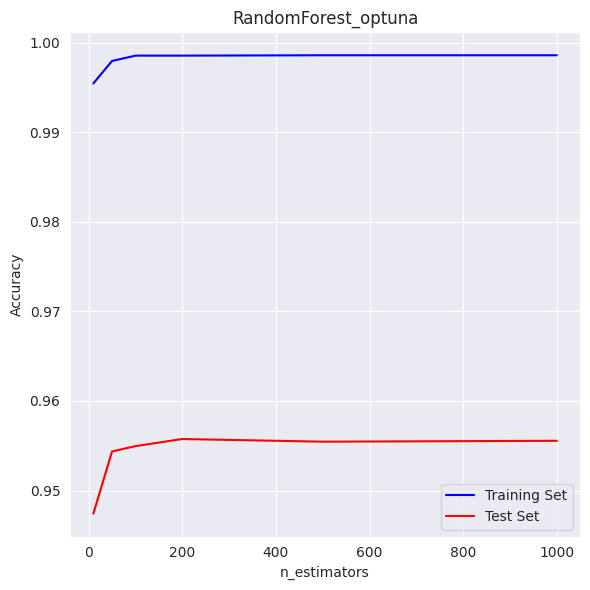

In [35]:
def create_random_forest(trial: optuna.trial.Trial, n_estimators = None):
    return RandomForestClassifier(
        criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
        max_depth=trial.suggest_int("max_depth", 1, 500, log=True),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 100, log=True),
        max_features=trial.suggest_int("max_features", 2, len(X_train.columns), log=True),
        n_estimators=trial.suggest_int("n_estimators", 5, 500, log=True) if n_estimators is None else n_estimators,
        random_state=0
    )

estimator = OptunaSearchCV(cv, create_random_forest)
eval_estimator("RandomForest_optuna", estimator)
plot_accuracy_against_resource(
    "RandomForest_optuna",
    "n_estimators",
    [10, 50, 100, 200, 500, 1000],
    lambda n_estimators: create_random_forest(estimator.best_trial, n_estimators)
)
eval_estimator("RandomForest_max_resource", create_random_forest(estimator.best_trial, 1000))

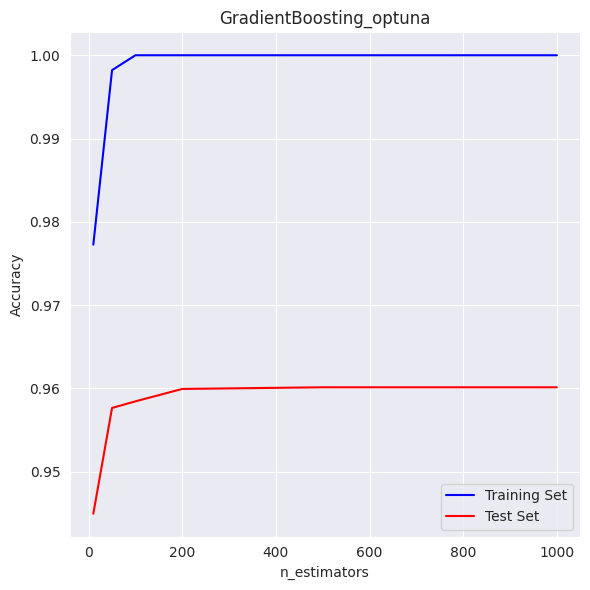

In [37]:
def create_gradient_boosting(trial: optuna.trial.Trial, n_estimators = None):
    return GradientBoostingClassifier(
        max_depth=trial.suggest_int("max_depth", 1, 50, log=True),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 100, log=True),
        max_features=trial.suggest_int("max_features", 2, len(X_train.columns), log=True),
        n_estimators=trial.suggest_int("n_estimators", 5, 500, log=True) if n_estimators is None else n_estimators,
        random_state=0
    )

estimator = OptunaSearchCV(cv, create_gradient_boosting)
eval_estimator("GradientBoosting_optuna", estimator)
plot_accuracy_against_resource(
    "GradientBoosting_optuna",
    "n_estimators",
    [10, 50, 100, 200, 500, 1000],
    lambda n_estimators: create_gradient_boosting(estimator.best_trial, n_estimators)
)
eval_estimator("GradientBoosting_max_resource", create_gradient_boosting(estimator.best_trial, 1000))

Коррекция тренировочного времени: чтобы натренировать модель с подобранными гиперпараметрами и с увеличенными вычислительными ресурсами (увеличенным числом деревьев/итераций), нужно сначала подобрать эти гиперпараметры. Поэтому к тренировочному времени моделей с суффиксом "max_resource" добавляется время подбора гиперпараметров, предшествующего их тренировке, а также выставляется число испробованных наборов гиперпараметров.

In [38]:
for i in range(len(estimator_names)):
    if estimator_names[i].endswith("_max_resource"):
        train_times[i] += train_times[i - 1]
        trials[i] = trials[i - 1]

Сортировка моделей по точности

In [40]:
accuracy, train_times, run_times, recall, roc_auc, precision, estimator_names, confusion_matrices, trials = zip(*sorted(zip(accuracy, train_times, run_times, recall, roc_auc, precision, estimator_names, confusion_matrices, trials), reverse=True))

## Результаты

В приведённой далее таблице:
- суффиксом "default" помечены модели с гиперпараметрами по умолчанию
- суффиксом "optuna" помечены модели с гиперпараметрами, подобранными с помощью `BoTorchSampler` из фреймворка Optuna примерно за два часа, более точное значение см. в столбце "Time to train"
- суффиксом "max_resource" помечены модели из предыдущего пункта с увеличенными вычислительными ресурсами (увеличенным числом деревьев/итераций)

In [41]:
pd.DataFrame({
        'Accuracy': [f'{x:.4f}' for x in accuracy],
        'Recall': [f'{x:.4f}' for x in recall],
        'Roc_Auc': [f'{x:.4f}' for x in roc_auc],
        'Precision': [f'{x:.4f}' for x in precision],
        'Trials': trials,
        'Time to train, sec': [f'{x:.0f}' for x in train_times],
        'Time to run (on test), sec': [f'{x:.2f}' for x in run_times],
    }, index=estimator_names)

,Accuracy,Recall,Roc_Auc,Precision,Trials,"Time to train, sec","Time to run (on test), sec"
GradientBoosting_max_resource,0.9601,0.9592,0.9600,0.9482,30,8157,0.94
GradientBoosting_optuna,0.9601,0.9585,0.9599,0.9488,30,7911,0.84
CatBoost_max_resource,0.9600,0.9594,0.9599,0.9477,8,7331,0.05
LGBM_optuna,0.9600,0.9601,0.9600,0.9471,278,7233,0.38
CatBoost_default,0.9597,0.9603,0.9598,0.9463,1,19,0.06
LGBM_max_resource,0.9592,0.9592,0.9592,0.9462,278,7243,0.60
CatBoost_optuna,0.9574,0.9566,0.9573,0.9446,8,7300,0.05
XGB_max_resource,0.9566,0.9543,0.9563,0.9449,37,8038,0.36
XGB_optuna,0.9562,0.9529,0.9557,0.9450,37,7849,0.28
HistGradientBoosting_max_resource,0.9562,0.9571,0.9563,0.9414,163,7230,0.11


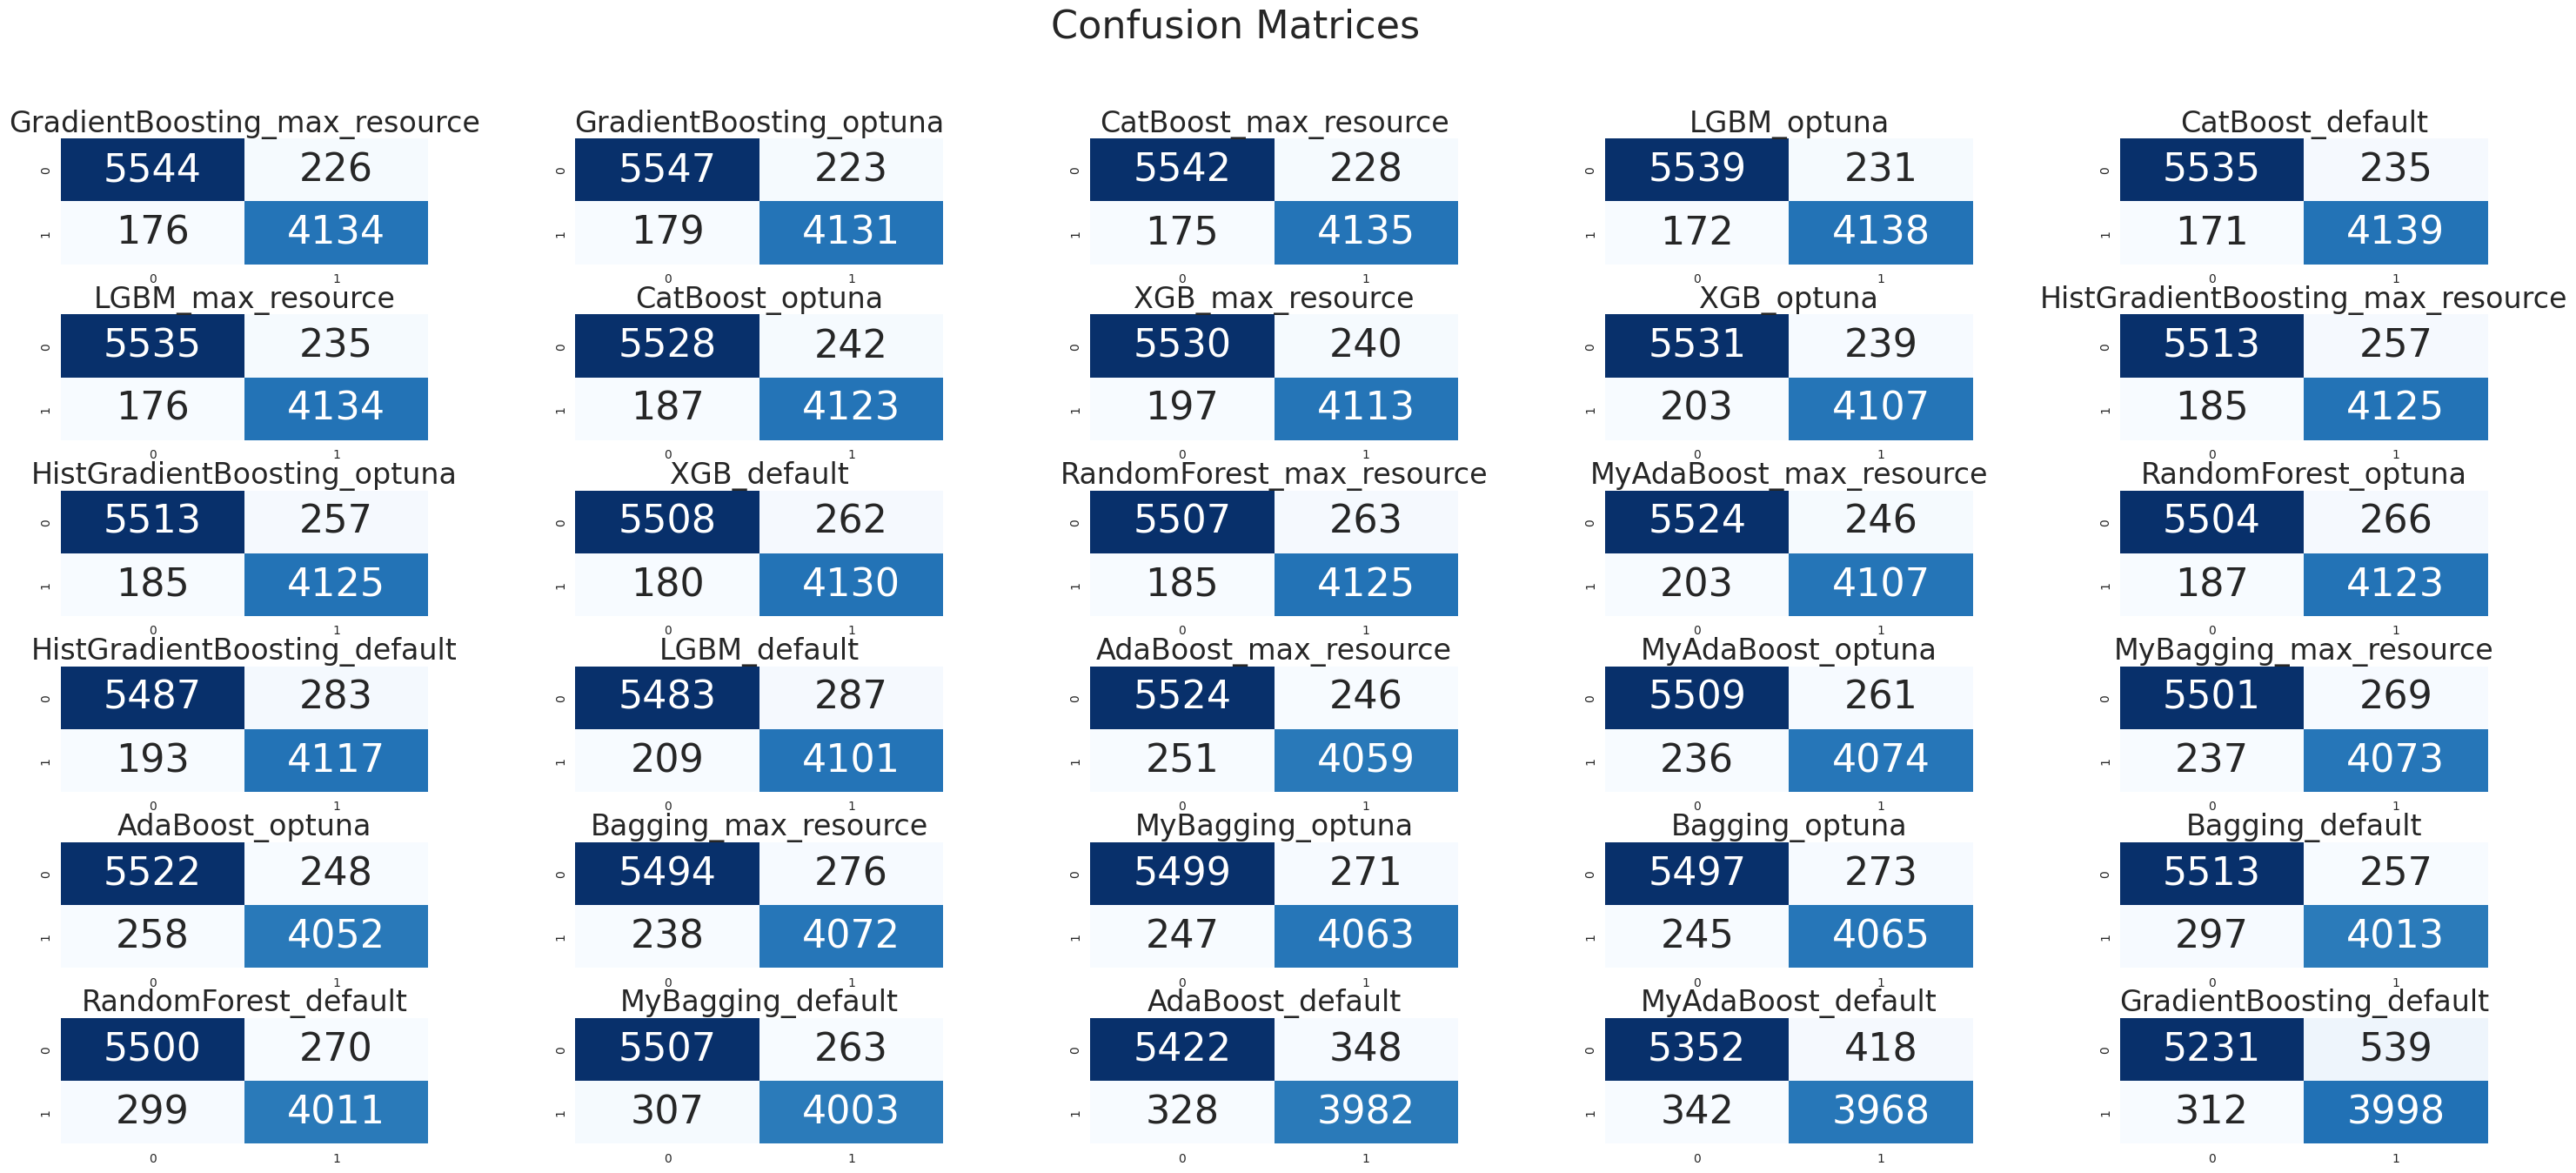

In [42]:
plt.figure(figsize=(36, 15))
plt.suptitle("Confusion Matrices", fontsize=32)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(len(confusion_matrices)):
    plt.subplot(6, 5, i + 1)
    plt.title(estimator_names[i], fontsize=24)
    sns.heatmap(confusion_matrices[i], annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 32})

plt.show()

Среди рассмотренных моделей наилучшую точность 96.01% показали `GradientBoosting_max_resource`, `GradientBoosting_optuna`.

Однако стоит так же отметить, что `CatBoost_max_resource` уступает им по точности всего на 0.01% и обрабатывает тестовый набор данных более чем в 10 раз быстрее: 0.05 секунд против соответственно 0.94 и 0.84 секунд.

Также стоит обратить внимание на то, что для `CatBoost` отведённых двух часов хватило только для того, чтобы испробовать всего 8 наборов гипперпараметров, что не дало улучшения точности по сравнению со значениями по умолчанию. Не исключается, что точность может повыситься, если дольше подбирать гиперпараметры.